[View in Colaboratory](https://colab.research.google.com/github/Luvata/PatternRecognition/blob/master/Pattern2.ipynb)

# Pattern 2 candles

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator
from datetime import timedelta
from matplotlib.finance import candlestick_ohlc
from google.colab import files

In [11]:
!ls

AAPL.csv  BAC.csv   datalab    INTC.csv  JPM.csv   __pycache__	WMT.csv
AMZN.csv  CSCO.csv  GOOGL.csv  JNJ.csv	 MSFT.csv  util.py


In [0]:
stock_code = ['AAPL','JPM','GOOGL','AMZN','MSFT','JNJ','BAC','WMT','INTC','CSCO']

In [13]:
import util

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [0]:
list_threshold = [0.5,0.75,1,2,3]

In [18]:
stocks = []
for code in stock_code :
  df = pd.read_csv(code+'.csv',
                   index_col=0,
                   parse_dates=True,
                   infer_datetime_format=True)
  print(code,df.shape)
  stocks.append(df)
  
print('total: ',len(stocks))

AAPL (4600, 5)
JPM (4600, 5)
GOOGL (3438, 5)
AMZN (4600, 5)
MSFT (4600, 5)
JNJ (4600, 5)
BAC (4600, 5)
WMT (4600, 5)
INTC (4600, 5)
CSCO (4600, 5)
total:  10


In [0]:
def lookbackward_15days(data,index,down=True):
  # defaults for Hammer : 8/15 days down
  count = 1
  day = 0
  l = data.shape[0]
  while(count < 16):
    next_index = index + count
    if(next_index > l-1):
      return day
    row = data.iloc[next_index]
    close = row.close
    open = row.open
    # print(open,close)
    if(down):
      if (open > close):
        day +=1
      # print(next_index,open,close)
    else:
      if(close > open) :
        day += 1
    count += 1
    
  return day

def lookforward_15days(data,index,down=False): 
  # default for Hammer : 8/15 days up
  count = 1
  day = 0
  while(count < 16):
    next_index = index - count
    if(next_index < 0) :
      return day
    row = data.iloc[next_index]
    close = row.close
    open = row.open
    if(down):
      if (open > close):
        day +=1
    else:
      if(close > open):
        day+=1
    count += 1
  return day



In [0]:
def plot_pattern(quotes,title,pattern_name,index):
    # quotes : pandas dataframe
    # index : ngày xuất hiện pattern
    # sample : plot_candle2(AP_df,title='Test',pattern_name='Hanging Man',selected_date='2005-04-29',date1='2005-04-07',date2='2005-05-25')        
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    l = quotes.shape[0]
    d1 = index + 16 if index +15 < l else l-1  # 15 ngày trước   
    d2 = index - 15 if index - 15 >= 0 else 0 # ngày sau
    # print(index,'date 1 : ',d1,'date 2 :',d2)
    # select desired range of dates
    quotes2 = quotes.iloc[range(d2,d1)]
    # print(quotes2.shape)
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    # ax.xaxis.set_minor_formatter(dayFormatter)

    # plot_day_summary(ax, quotes, ticksize=3)
    candlestick_ohlc(ax, zip(mdates.date2num(quotes2.index.to_pydatetime()),
                         quotes2['open'], quotes2['high'],
                         quotes2['low'], quotes2['close']),
                 width=0.6,colordown='red',colorup='green')

    ax.xaxis_date()
    ax.autoscale_view()
    fig.set_size_inches(20,10)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title(title)
    ymin, ymax = ax.get_ylim()
    selected_date = quotes.iloc[[index]].index.to_pydatetime()
    
    ax.annotate(pattern_name, 
                xy = (selected_date,quotes.loc[selected_date].high ),
                xytext=(selected_date,quotes.loc[selected_date].high + (ymax-ymin)/6 ),
                arrowprops = dict(facecolor='black',width=1,shrink=0.25))
    plt.show()

Thị trường : xu hướng tăng mạnh</br>
Xuất hiện cặp 2 cây cây nến thỏa mãn yêu cầu công thức sau: </br>
Thân cây nến số 1: M = (Open – Close) </br>
Thân cây nến số 2: N = (Close – Open) </br>
M / N > = Threshold </br>
15 cây nến sau nó mà có 8 cây (ko cần liên tiếp) là cây nến giảm giá 

In [23]:
stocks[0].iloc[[0]]

,open,high,low,close,volume
timestamp,,,,,
2018-04-16,175.0301,176.19,174.8301,175.8881,14756807


In [0]:
def DarkCloudCover(data,threshold):
  # backward down = False, forward down = True
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(1,l):
    day1 = data.iloc[[i-1]] # ngày mới hơn  
    day2 = data.iloc[[i]] 
    
    M = day1.open[0] - day1.close[0]
    N = day2.close[0] - day2.open[0]
    
    if N != 0 and M>0 and M/N > threshold :
      # check if >8/15 days before day 2 is up
      if(lookbackward_15days(data,i,down=False) >=8 ):
        appear.append(i)
        if(lookforward_15days(data,i-1,down=True) >=8):
          correct.append(i)
          
  return appear,correct

In [0]:
appear,correct = DarkCloudCover(stocks[0],threshold=0.5)

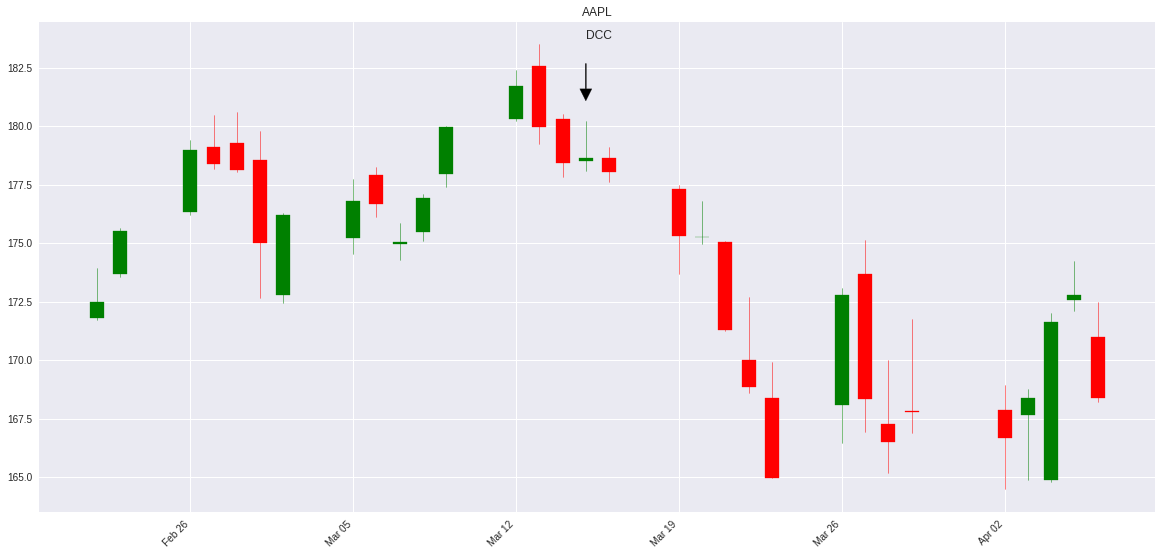

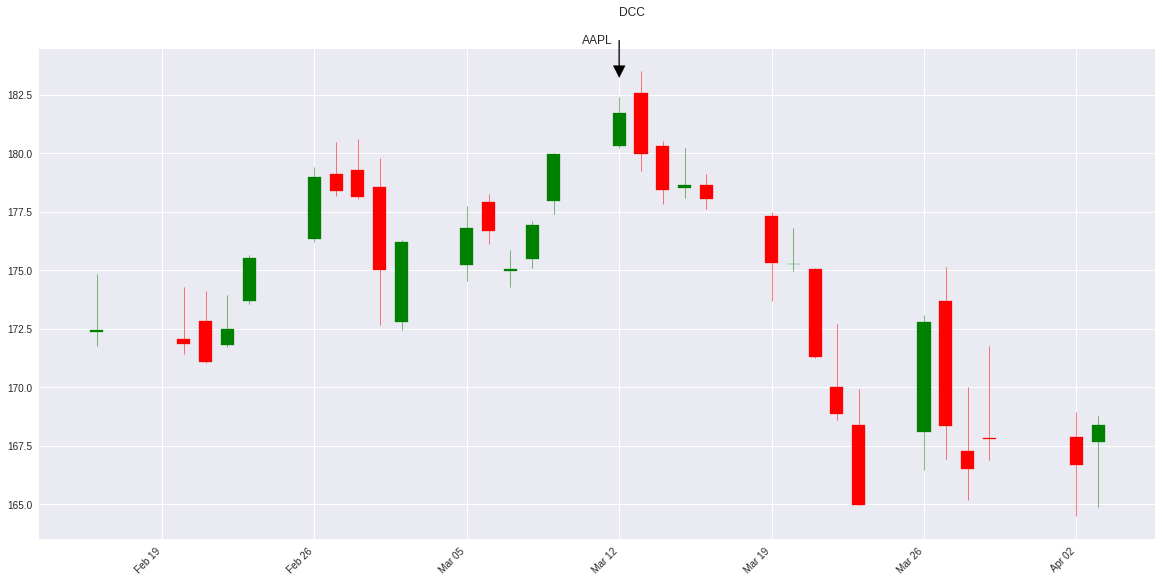

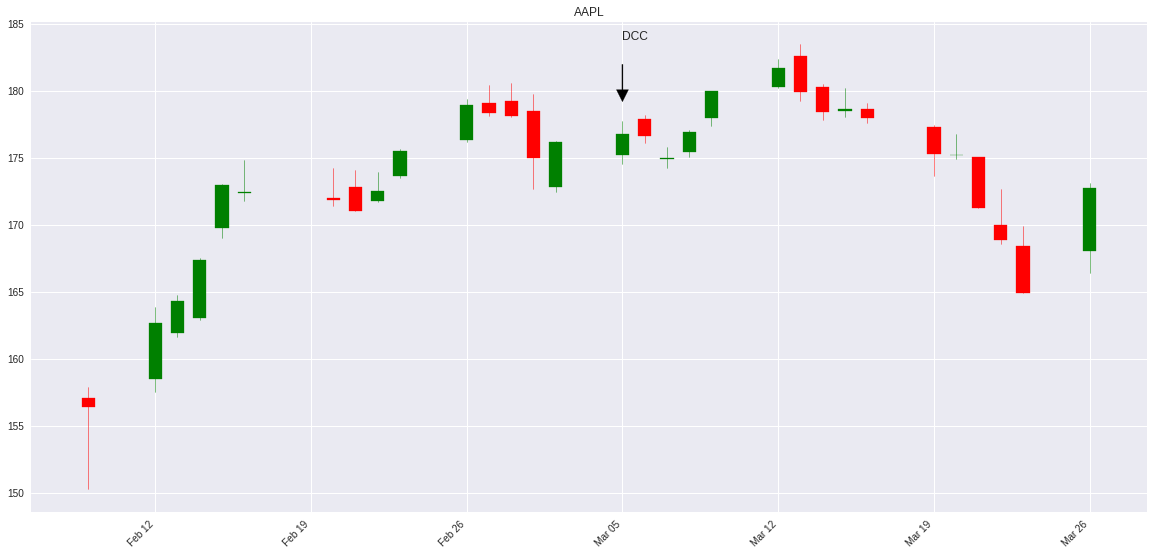

In [91]:
for i in range(3):
  index = correct[i]
  plot_pattern(stocks[0],'AAPL','DCC',index)

In [92]:
print(len(appear),len(correct))

392 172


In [0]:
q = stocks[0]

In [94]:
type(q.iloc[range(15,45)])

pandas.core.frame.DataFrame

In [0]:
def Piercing(data,threshold):
  # backward down = False, forward down = True
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(1,l):
    day1 = data.iloc[[i-1]]
    day2 = data.iloc[[i]]
    
    M = day1.close[0] - day1.open[0] 
    N = day2.open[0] - day2.close[0]
    
    # 
    if N != 0 and M > 0 and M/N > threshold  :
      # check if >8/15 days before day 2 is down
      if(lookbackward_15days(data,i,down=True) >=8 ):
        appear.append(i)
        if(lookforward_15days(data,i-1,down=False) >=8):
          correct.append(i)
          
  return appear,correct

In [0]:
appear,correct = Piercing(stocks[0],threshold=0.5)

In [97]:
print(len(appear),len(correct))

413 184


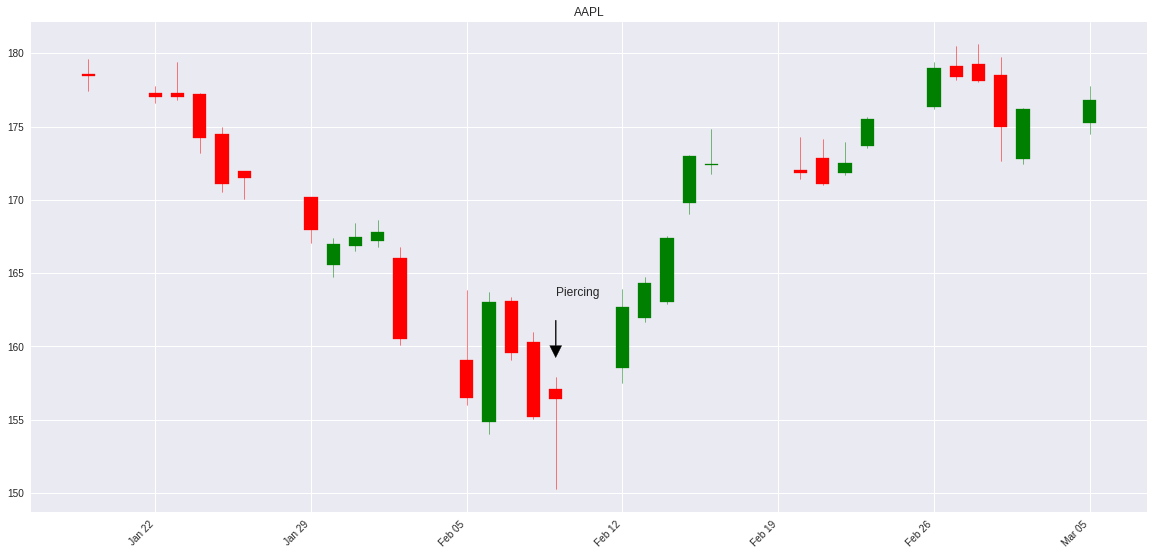

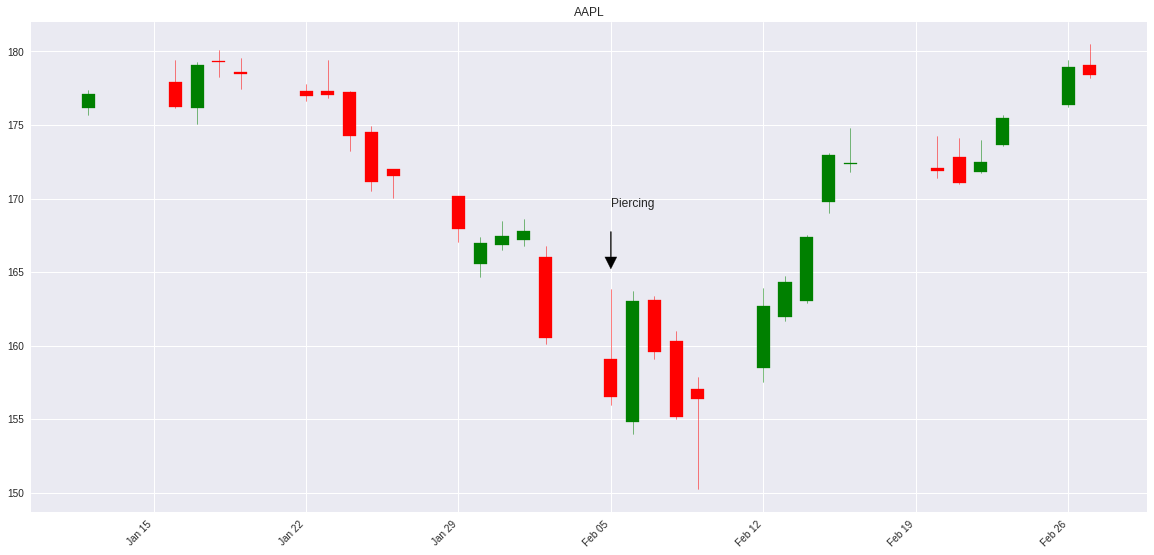

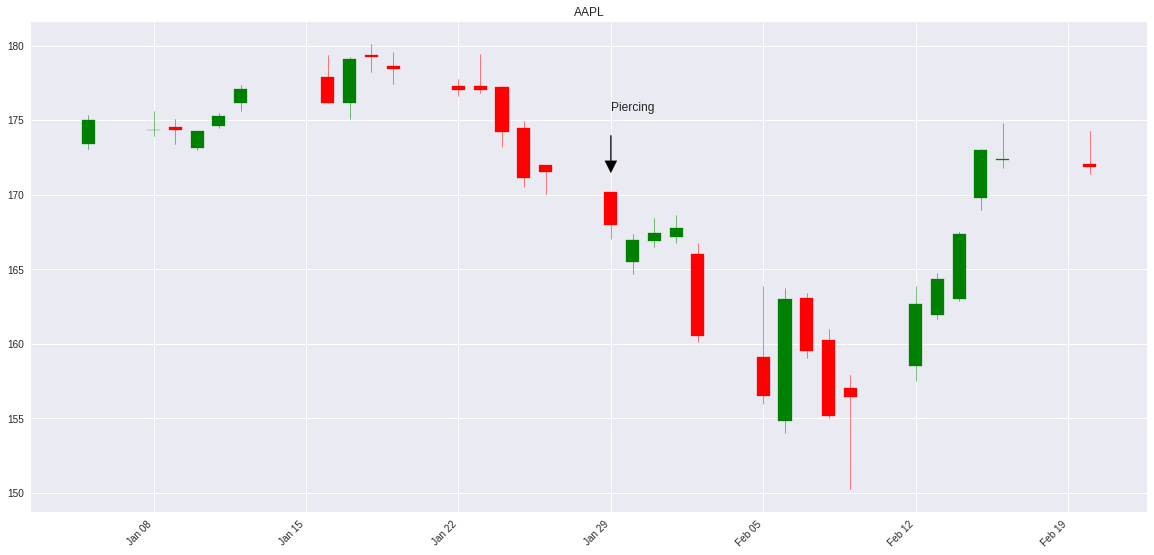

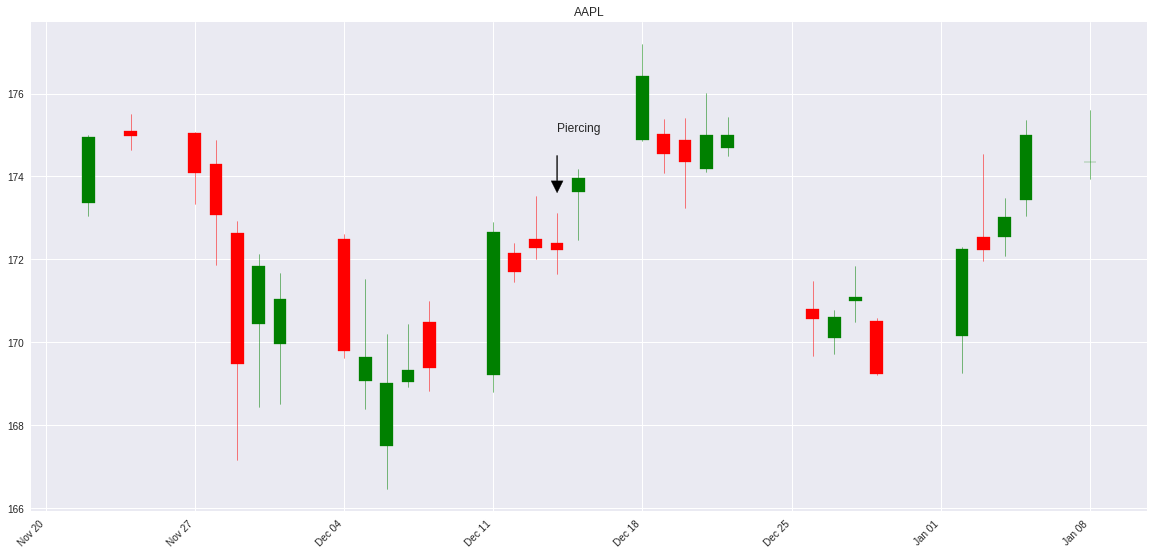

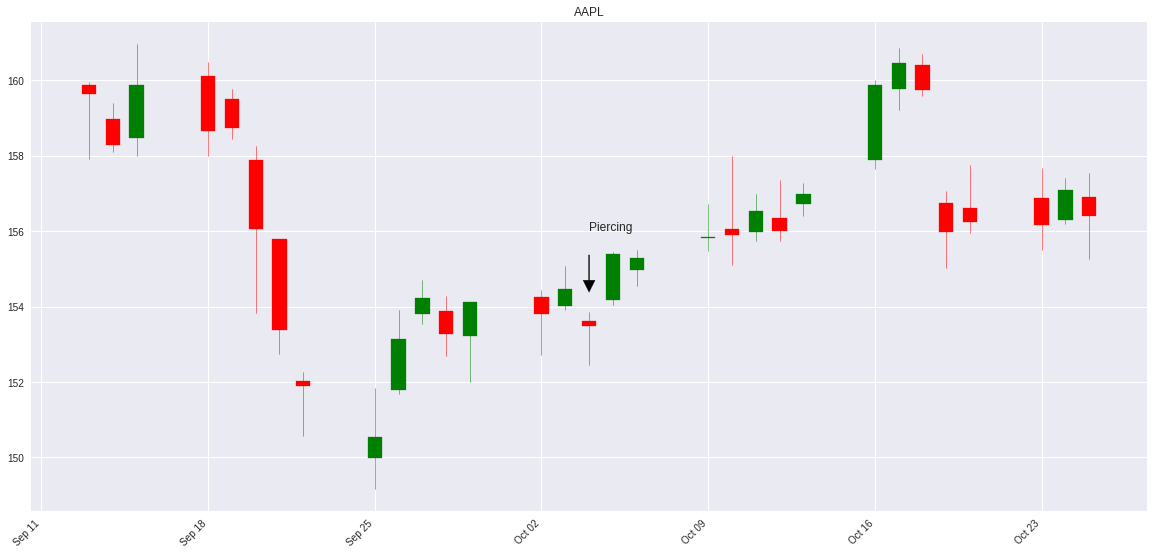

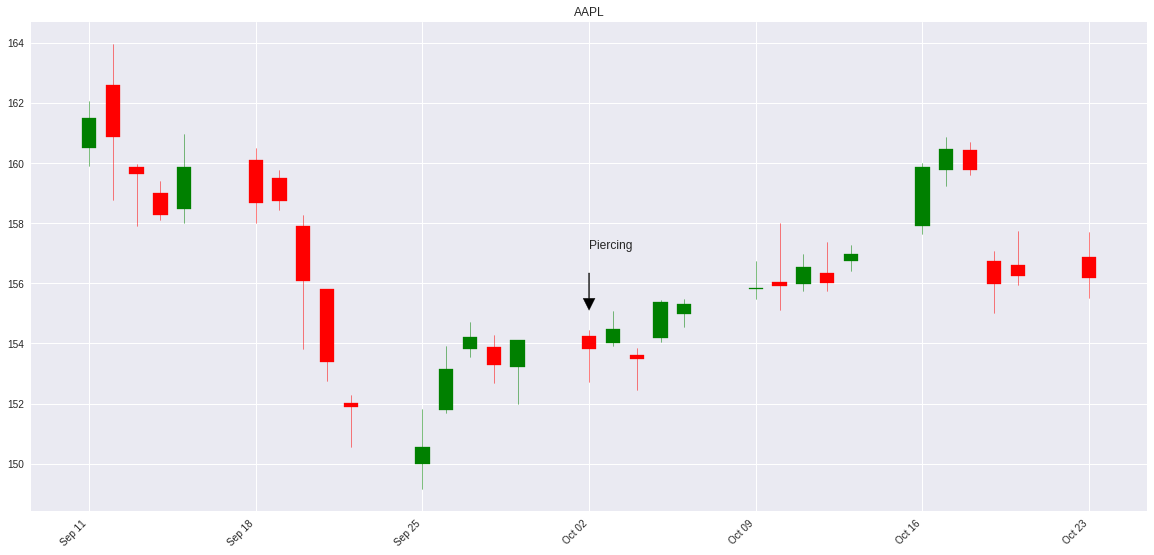

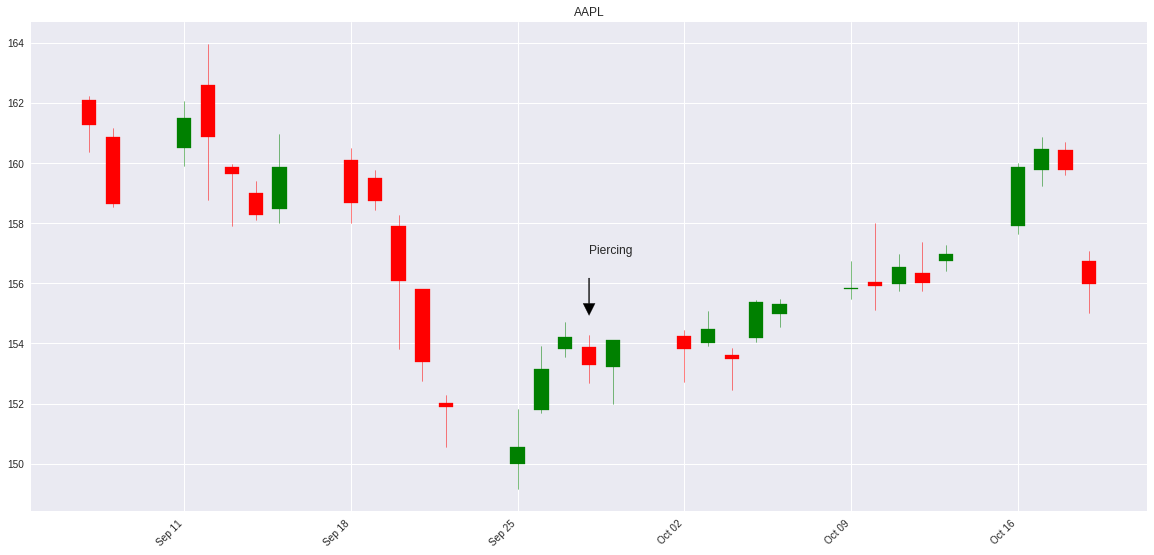

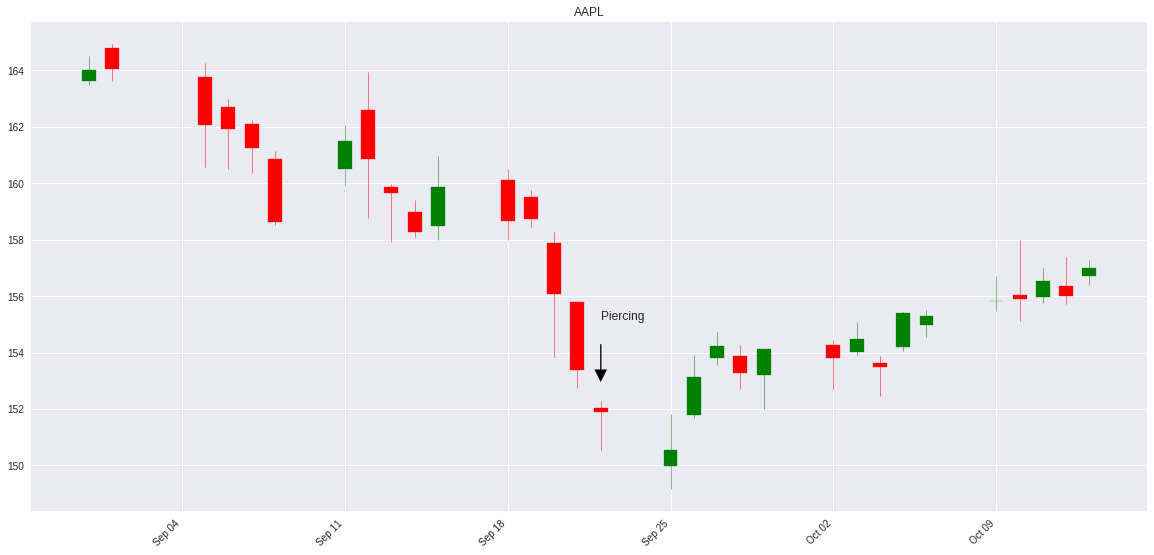

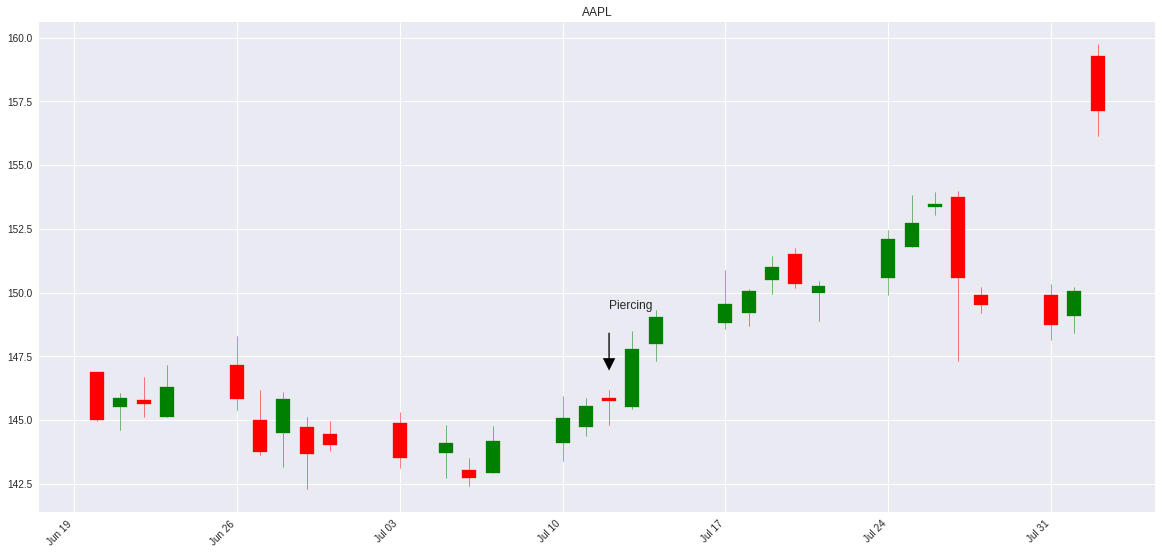

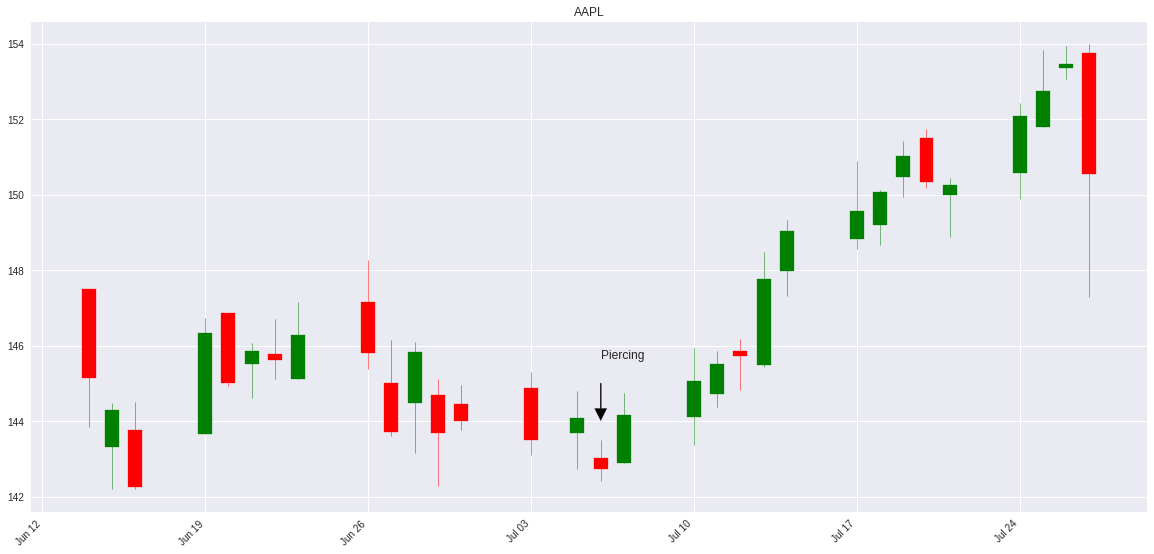

In [99]:
for i in range(10):
  index = correct[i]
  plot_pattern(stocks[0],'AAPL','Piercing',index)

In [0]:
summary = []
for t in list_threshold:
  for i in range(len(stocks)):
    code = stock_code[i]
    data = stocks[i]
    a1,c1 = DarkCloudCover(data,threshold=t)
    summary.append({'threshold':t,
                    'code':code,
                    'appear':len(a1),
                    'acc':len(c1),
                    'pattern':'DCC'})
    a2,c2 = Piercing(data,threshold=t)
    summary.append({'threshold':t,'code':code,'appear':len(a2),'acc':len(c2),'pattern':'PIER'})
    

In [0]:
df = pd.DataFrame(summary)
df.to_csv('pattern2.csv')
from google.colab import files
files.download('pattern2.csv')

In [107]:
df_05 = df[df.threshold == 0.5]
df_05

,acc,appear,code,pattern,threshold
0,172,392,AAPL,DCC,0.5
1,184,413,AAPL,PIER,0.5
2,164,354,JPM,DCC,0.5
3,159,382,JPM,PIER,0.5
4,152,286,GOOGL,DCC,0.5
5,143,323,GOOGL,PIER,0.5
6,173,391,AMZN,DCC,0.5
7,195,413,AMZN,PIER,0.5
8,172,359,MSFT,DCC,0.5
9,170,401,MSFT,PIER,0.5


In [110]:
df_05.loc[df_05.pattern == 'DDC']

,acc,appear,code,pattern,threshold


In [112]:
stock_code.sorted()

['AAPL', 'JPM', 'GOOGL', 'AMZN', 'MSFT', 'JNJ', 'BAC', 'WMT', 'INTC', 'CSCO']

In [0]:
df.rename(columns={'acc':'correct'},inplace=True)

In [0]:
df['acc'] = df['correct']/df['appear']

In [0]:
df

In [141]:
df.loc[(df['threshold'] == 0.5 ) & (df['pattern'] == 'PIER')].acc.sum()/10

0.4408369271699997

In [0]:
list_pier = []
list_dcc = []
for i in list_threshold:
  p = df.loc[(df['threshold'] == i ) & (df['pattern'] == 'PIER')].acc.sum()/10
  list_pier.append(p)
  d = df.loc[(df['threshold'] == i ) & (df['pattern'] == 'DCC')].acc.sum()/10
  list_dcc.append(d)

In [0]:
acc_all = pd.DataFrame({
    'PIER' : list_pier,
    'DCC' : list_dcc
})

Text(0,0.5,'Accuracy')

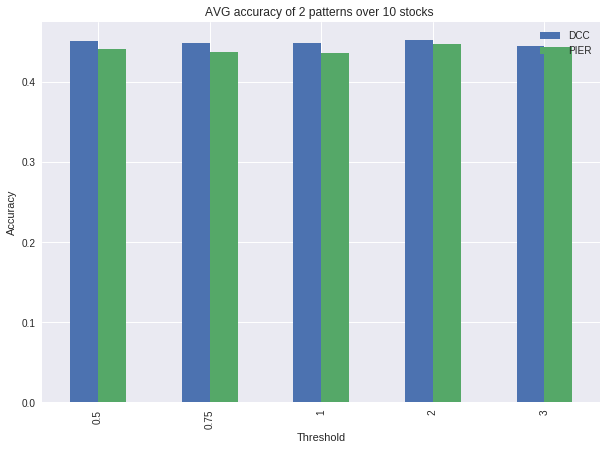

In [151]:
ax = acc_all.plot(kind='bar',figsize=(10,7))
ax.set_xticklabels(list_threshold)
ax.set_title('AVG accuracy of 2 patterns over 10 stocks ')
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')